In [2]:
import open_clip
from open_clip import tokenizer

/home/poorna/anaconda3/envs/rag_langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "ViT-H-14"
checkpoint = "laion2b_s32b_b79k"

In [4]:
model, _, preprocess = open_clip.create_model_and_transforms(
                model_name=model_name, pretrained=checkpoint
            )



In [8]:
tokenizer = open_clip.get_tokenizer(model_name)

In [9]:
import pypdfium2 as pdfium

In [10]:
def get_images_from_pdf(pdf_path, img_dump_path = "./docs/"):
    pdf = pdfium.PdfDocument(pdf_path)
    n_pages = len(pdf)
    for page_number in range(60):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale=1, rotation=0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil()
        pil_image.save(f"{img_dump_path}/img_{page_number + 1}.jpg", format="JPEG")
get_images_from_pdf("./doc.pdf")

In [60]:
_6_img = "./docs2/img_14.jpg"

In [61]:
_6_text = "Why Datadog for cloud"

In [62]:
# _6_text = """This book deals with the analysis and design of analog CMOS integrated circuits, emphasizing fundamentals as well as new paradigms that students and practicing engineers need to master in today’s
# industry. Since analog design requires both intuition and rigor, each concept is first introduced from an
# intuitive perspective and subsequently treated by careful analysis. The objective is to develop both a solid
# foundation and methods of analyzing circuits by inspection so that the reader learns what approximations
# can be made in which circuits and how much error to expect in each approximation. This approach also
# enables the reader to apply the concepts to bipolar circuits with little additional effort.
# I have taught most of the material in this book both at UCLA and in industry, polishing the order, the
# format, and the content with every offering. As the reader will see throughout the book, I follow four
# “golden rules” in writing (and teaching): (1) I explain why the reader needs to know the concept that is
# to be studied; (2) I put myself in the reader’s position and predict the questions that he/she may have
# while reading the material for the first time; (3) With Rule 2 in mind, I pretend to know only as much
# as the (first-time) reader and try to “grow” with him/her, thereby experiencing the same thought process;
# (4) I begin with the “core” concept in a simple (even imprecise) language and gradually add necessary
# modifications to arrive at the final (precise) idea. The last rule is particularly important in teaching circuits
# because it allows the reader to observe the evolution of a topology and hence learn both analysis and
# synthesis."""

In [63]:
_22_image = "./docs2/img_8.jpg"

In [64]:
_22_text = "history of innovation"

In [65]:
# _22_text = """Unfortunately, the cable exhibits a finite bandwidth, attenuating high frequencies and distorting the data
# as it reaches Laptop 2. This device must now perform sensing and processing, the former requiring an
# analog circuit (called an “equalizer”) that corrects the distortion. For example, since the cable attenuates
# high frequencies, we may design the equalizer to amplify such frequencies, as shown conceptually by the
# 1/|H| plot in Fig. 1.3.
# The reader may wonder whether the task of equalization in Fig. 1.3 could be performed in the digital
# domain. That is, could we directly digitize the received distorted signal, digitally correct for the cable’s
# limited bandwidth, and then carry out the standard USB signal processing? Indeed, this is possible if
# the ADC required here demands less power and less complexity than the analog equalizer. Following a
# detailed analysis, the analog designer decides which approach to adopt, but we intuitively know that at very
# high data rates, e.g., tens of gigabits per second, an analog equalizer proves more efficient than an ADC.
# The above equalization task exemplifies a general trend in electronics: at lower speeds, it is more
# efficient to digitize the signal and perform the required function(s) in the digital domain, whereas at
# higher speeds, we implement the function(s) in the analog domain. The speed boundary between these
# two paradigms depends on the nature of the problem, but it has risen over time."""

In [66]:
texts = [_6_text,_22_text]
images = [_6_img,_22_image]

In [67]:
text_features = []
for text in texts:
    # Tokenize the text
    tokenized_text = tokenizer(text)

    # Encode the text to get the embeddings
    embeddings_tensor = model.encode_text(tokenized_text)

    # Normalize the embeddings
    norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
    normalized_embeddings_tensor = embeddings_tensor.div(norm)

    # Convert normalized tensor to list and add to the text_features list
    embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()
    text_features.append(embeddings_list)

In [68]:
from PIL import Image as _PILImage
pil_images = [_PILImage.open(uri) for uri in images]
image_features = []
for pil_image in pil_images:
    # Preprocess the image for the model
    preprocessed_image = preprocess(pil_image).unsqueeze(0)

    # Encode the image to get the embeddings
    embeddings_tensor = model.encode_image(preprocessed_image)

    # Normalize the embeddings tensor
    norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
    normalized_embeddings_tensor = embeddings_tensor.div(norm)

    # Convert tensor to list and add to the image_features list
    embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()

    image_features.append(embeddings_list)

In [69]:
import numpy as np

In [70]:
img_features_np = np.array(image_features)
text_features_np = np.array(text_features)

In [71]:
similarity = np.matmul(text_features_np, img_features_np.T)

In [72]:
similarity

array([[0.44067806, 0.23079673],
       [0.08438197, 0.35354585]])

In [73]:
import matplotlib.pyplot as plt

In [74]:
image_opens = [_PILImage.open(x).convert("RGB") for x in images]
text_starts = [x[:50] for x in texts]

Text(0.5, 1.0, 'Cosine similarity between text and image features')

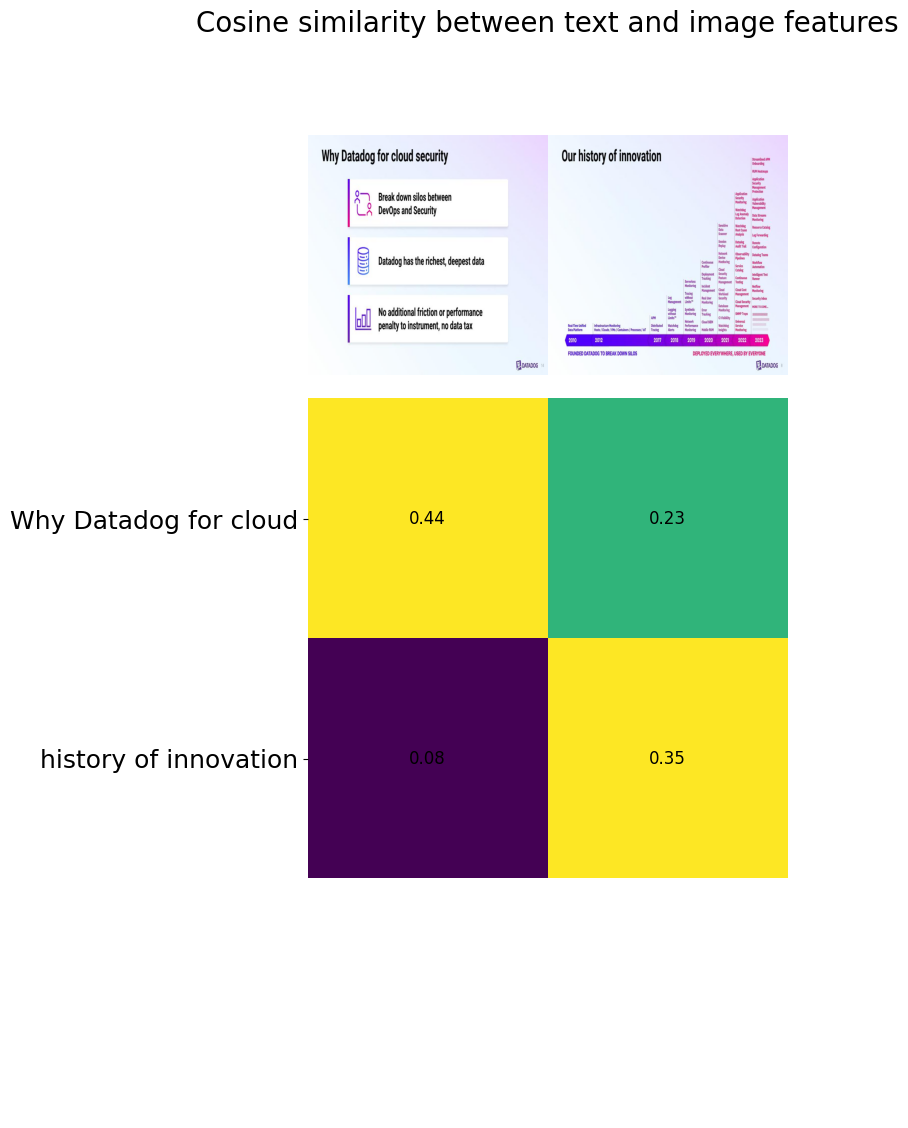

In [75]:
# Plot
count = len(text_starts)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), text_starts, fontsize=18)
plt.xticks([])
for i, image in enumerate(image_opens):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

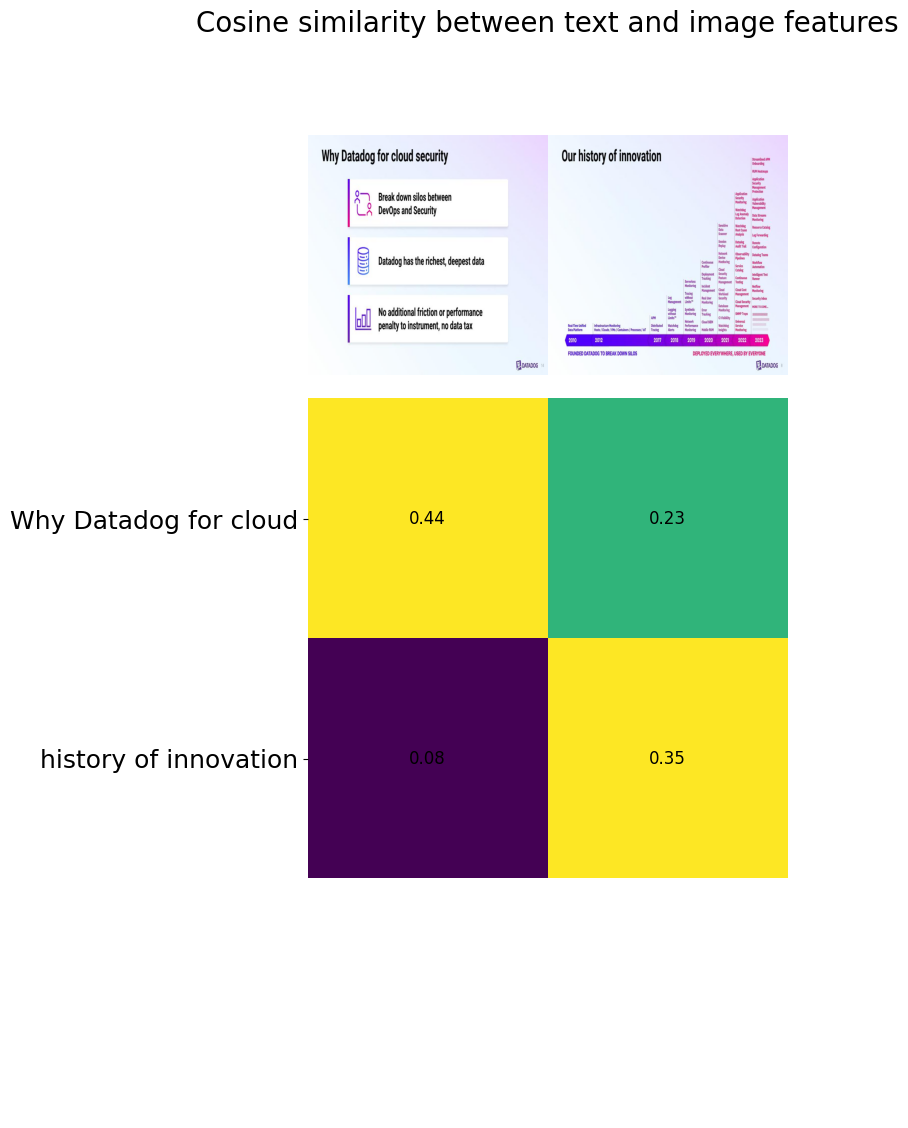

In [76]:
# Plot
count = len(text_starts)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), text_starts, fontsize=18)
plt.xticks([])
for i, image in enumerate(image_opens):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)